<a href="https://colab.research.google.com/github/DIVA-DIA/Layout-Analysis-using-a-Light-CNN/blob/main/L-U-NET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from torchvision import models
from torchsummary import summary

In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as albu

import time
import glob
from tqdm.notebook import tqdm

from torchvision.datasets.folder import pil_loader
import random
import torch.nn.init as init

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
cd='/content/drive/My Drive/Colab Notebooks/'
%cd /content/drive/My Drive/Colab Notebooks/

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks


In [ ]:
img_DIR = 'path_to_images'
mask_DIR = 'path_to_groundtruth'

In [ ]:
x_train_dir = os.path.join(img_DIR, 'training')
y_train_dir = os.path.join(mask_DIR, 'training')

x_valid_dir = os.path.join(img_DIR, 'validation')
y_valid_dir = os.path.join(mask_DIR, 'validation')

x_test_dir = os.path.join(img_DIR, 'public-test')
y_test_dir = os.path.join(mask_DIR, 'public-test')

In [ ]:
print('the number of image/label in the train: ',len(os.listdir(x_train_dir)))
print('the number of image/label in the validation: ',len(os.listdir(x_valid_dir)))
print('the number of image/label in the test: ',len(os.listdir(x_test_dir)))

In [ ]:
train_img_paths = glob.glob(os.path.join(x_train_dir, "*.jpg"))
train_mask_paths = glob.glob(os.path.join(y_train_dir, "*.gif"))
val_img_paths = glob.glob(os.path.join(x_valid_dir, "*.jpg"))
val_mask_paths = glob.glob(os.path.join(y_valid_dir, "*.gif"))
test_img_paths = glob.glob(os.path.join(x_test_dir, "*.jpg"))
test_mask_paths = glob.glob(os.path.join(y_test_dir, "*.gif"))

In [ ]:
train_img_paths.sort()
train_mask_paths.sort()

In [ ]:
print(train_img_paths[:5])
print(train_mask_paths[:5])

In [ ]:
val_img_paths.sort()
val_mask_paths.sort()

In [ ]:
print(val_img_paths[:5])
print(val_mask_paths[:5])

In [ ]:
test_img_paths.sort()
test_mask_paths.sort()

In [ ]:
print(test_img_paths[:5])
print(test_mask_paths[:5])

In [ ]:
#labels
background = [0,0,0] #black
comments = [0, 255, 0] #green
decor = [255, 0, 0] #red
text = [0, 0, 255] #blue

In [ ]:
# mask from RGB to labels (HxW)
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == background,axis=-1)] = 0
    label_seg [np.all(label==comments,axis=-1)] = 1
    label_seg [np.all(label==decor,axis=-1)] = 2
    label_seg [np.all(label==text,axis=-1)] = 3
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

In [ ]:
class DIVA(Dataset):

    def __init__(
            self, 
            imagePaths, 
            maskPaths, 

    ):
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths

        

    def __getitem__(self, idx):

        # read data
            img_path = self.imagePaths[idx]
            mask_path = self.maskPaths[idx]
            read_img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            read_img = cv2.resize(read_img, (1152,1728), interpolation = cv2.INTER_AREA)
            img = 2*((read_img - read_img.min()) / (read_img.max() - read_img.min())) - 1
            mask = pil_loader(mask_path)
            #mask to numpy
            np_mask_diva = np.array(mask)
            #mask from RGB to labels (HxW)
            mask = rgb_to_2D_label(np_mask_diva)
            #Image and mask normalization
            Transforms = transforms.Compose([transforms.ToTensor()])
            img = Transforms(img)
            mask = torch.from_numpy(mask).long()

            return img, mask

    def __len__(self):
        return len(self.imagePaths)

In [ ]:
from torch.utils.data import RandomSampler

In [ ]:
def get_sampler(dataset, seed=123):
    generator = torch.Generator()
    generator.manual_seed(seed)
    sampler = RandomSampler(dataset, generator=generator)
    return sampler

In [ ]:
#Train, Validationのデータセットを作成

train_dataset = DIVA(
    train_img_paths, 
    train_mask_paths, 
    
)

valid_dataset = DIVA(
    val_img_paths, 
    val_mask_paths, 
    
)

train_loader = DataLoader(train_dataset, batch_size=1, sampler=get_sampler(train_dataset), num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

In [ ]:
# Reading the image and corrosponding mask
image_batch, mask_batch = next(iter(train_loader))

image_batch.shape, mask_batch.shape

In [ ]:
def dil_block(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1, dilation=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        
        nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1, dilation=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        
        nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=2, dilation=2),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),

        nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=2, dilation=2),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        
        
        )
    return conv


def encoding_block(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        
        )
    return conv

def encoding_block1(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        
        nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        
        )
    return conv

In [ ]:
class unet_model(nn.Module):
    def __init__(self,out_channels=4,features=[16, 32]):
        super(unet_model,self).__init__()
        
        
        self.dil1 = dil_block(3,features[0])
        
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        
        self.dil2 = dil_block(features[0],features[0])
        
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        
        self.dil3 = dil_block(features[0],features[0])
        
        self.pool3 = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        
        self.dil4 = dil_block(features[0],features[0])
        
        self.pool4 = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        
        self.bott = encoding_block1(features[0],features[0])
        
        self.tconv1 = nn.ConvTranspose2d(features[0], features[0], kernel_size=2, stride=2)
        
        self.conv1 = encoding_block(features[1],features[0])
        
        self.tconv2 = nn.ConvTranspose2d(features[0], features[0], kernel_size=2, stride=2)
        
        self.conv2 = encoding_block(features[1],features[0])
        
        self.tconv3 = nn.ConvTranspose2d(features[0], features[0], kernel_size=2, stride=2)
        
        self.conv3 = encoding_block(features[1],features[0])
        
        self.tconv4 = nn.ConvTranspose2d(features[0], features[0], kernel_size=2, stride=2)
        
        self.conv4 = encoding_block1(features[1],features[0])
        
        
        self.final_layer = nn.Conv2d(features[0],out_channels, kernel_size=1)
        
    def forward(self,x):
        dil_1 = self.dil1(x) 
        
        pool_1 = self.pool1(dil_1)
        
        dil_2 = self.dil2(pool_1) 
        
        pool_2 = self.pool2(dil_2) 
        
        dil_3 = self.dil3(pool_2) 
        
        pool_3 = self.pool3(dil_3) 
        
        dil_4 = self.dil4(pool_3) 
        
        pool_4 = self.pool3(dil_4) 
        
        bott = self.bott(pool_4) 
        
        tconv_1 = self.tconv1(bott) 
        
        concat1 = torch.cat((tconv_1, dil_4), dim=1) 
        
        conv_1 = self.conv1(concat1) 
        
        tconv_2 = self.tconv2(conv_1) 
        
        concat2 = torch.cat((tconv_2, dil_3), dim=1)
        
        conv_2 = self.conv2(concat2) 
        
        tconv_3 = self.tconv3(conv_2) 
        
        concat3 = torch.cat((tconv_3, dil_2), dim=1) 
        
        conv_3 = self.conv3(concat3) 
        
        tconv_4 = self.tconv4(conv_3) 
        
        concat4 = torch.cat((tconv_4, dil_1), dim=1) 
        
        conv_4 = self.conv4(concat4) 
        
        
        x = self.final_layer(conv_4)
        
        return x

In [ ]:
device = "cuda" if torch.cuda.is_available() else "gpu"

In [ ]:
# initilize the model
model = unet_model().to(device)

In [ ]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        preds = torch.argmax(F.softmax(output, dim=1), dim=1)
        num_correct = (preds == mask).sum()
        num_pixels = torch.numel(preds)
        accuracy = float(num_correct) / float(num_pixels)
    return accuracy

In [ ]:
def mIoU(output, mask):
    with torch.no_grad():
        preds = torch.argmax(F.softmax(output, dim=1), dim=1)
        

        intersection = torch.logical_and(preds, mask).sum()
        union = torch.logical_or(preds, mask).sum()

        IoU = float(intersection + 1e-10) / float(union +1e-10)
    return IoU

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-05)
criterion = nn.CrossEntropyLoss()

In [ ]:
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []
train_IoU = []
val_IoU = []

In [ ]:
gradient_accumulation_steps = 5

In [ ]:
best_loss = np.Inf
best_iou_score = 0.0
epochs = 300
fit_time = time.time()
for epoch in range(epochs):
    print('Epoch: [{}/{}]'.format(epoch+1, epochs))
    
    trainloss = 0
    trainaccuracy = 0
    trainIoU = 0
    
    since = time.time()
    model.train()
    #for img,label in tqdm(train_loader):
    for index, batch in enumerate(train_loader):
        img, label = batch
        '''
            Traning the Model.
        '''
        optimizer.zero_grad()
        img=img.float() 
        img = img.to(device)
        label = label.to(device)
        model = model.cuda()
        output = model(img)
        loss = criterion(output,label)
        loss.backward()
        if (index + 1) % gradient_accumulation_steps == 0:
           optimizer.step()
        #scheduler.step()
        trainloss+=loss.item()
        trainaccuracy += pixel_accuracy(output, label)
        trainIoU += mIoU(output, label)
    
    #if(i%5==0):
        #show(img,output,label)

    
  
    model.eval()
    valloss = 0
    valaccuracy = 0
    valIoU = 0

    with torch.no_grad():
      for img_val,label_val in tqdm(valid_loader):
        '''
            Validation of Model.
        '''
        img_val=img_val.float()
        img_val = img_val.to(device)
        label_val = label_val.to(device)
        model = model.cuda()
        output_val = model(img_val)
        loss_val = criterion(output_val,label_val)
        valloss+=loss_val.item()
        valaccuracy += pixel_accuracy(output_val, label_val)
        valIoU += mIoU(output_val, label_val)
        
    train_loss.append(trainloss/len(train_loader))  
    train_accuracy.append(trainaccuracy/len(train_loader))
    train_IoU.append(trainIoU/len(train_loader))  
    val_loss.append(valloss/len(valid_loader)) 
    val_accuracy.append(valaccuracy/len(valid_loader))
    val_IoU.append(valIoU/len(valid_loader)) 

    # Save model if a better val IoU score is obtained
    if best_loss > valloss:
         best_loss = valloss
         torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, 'path to save the model')
         print('Loss_Model saved!') 
    
    # Save model if a better val IoU score is obtained
    if best_iou_score < valIoU:
         best_iou_score = valIoU
         torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, 'path to save the model')
         print('IOU_Model saved!')

    #print("epoch : {} ,train loss : {} ,valid loss : {} ,train acc : {} ,val acc : {} ".format(i,train_loss[-1],val_loss[-1],train_accuracy[-1],val_accuracy[-1]))
    print(#"Epoch:{}".format(epoch),
          "Train Loss: {}".format(trainloss/len(train_loader)),
          "Val Loss: {}".format(valloss/len(valid_loader)), 
          "Train mIoU:{}".format(trainIoU/len(train_loader)),
          "Val mIoU: {}".format(valIoU/len(valid_loader)),
          "Train Acc:{}".format(trainaccuracy/len(train_loader)),
          "Val Acc:{}".format(valaccuracy/len(valid_loader)),
          "Time: {:.2f}m".format((time.time()-since)/60))
print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))

In [ ]:
fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_subplot()
plt.plot(train_loss,color='b',label='train loss', marker='o')
plt.plot(val_loss,color='r',label = 'val loss', marker='o')
ax1.set_title("Loss")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
plt.legend()

In [ ]:
fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_subplot()
plt.plot(train_IoU,color='b',label='train IoU', marker='*')
plt.plot(val_IoU,color='r',label = 'val IoU', marker='*')
ax1.set_title("IoU")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('IoU')
plt.legend()

In [ ]:
fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_subplot()
plt.plot(train_accuracy,color='b',label='train acc', marker='*')
plt.plot(val_accuracy,color='r',label = 'val acc', marker='*')
ax1.set_title("Accuracy")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
plt.legend()

In [ ]:
# load the trained model
Test_model = unet_model().to(device) # initilize the model

In [ ]:
# load the model checkpoint
Test_checkpoint_iou = torch.load('load the model')
# load model weights state_dict
Test_model.load_state_dict(Test_checkpoint_iou['model_state_dict'])
print('Previously trained model weights state_dict loaded...')

In [ ]:
# create test dataset
test_dataset = DIVA(
    test_img_paths, 
    test_mask_paths, 
)

test_dataloader_realD = DataLoader(test_dataset)

In [ ]:
CLASSES = ['bg', 'line', 'hline', 'gline']

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import jaccard_score
from sklearn.metrics import precision_recall_fscore_support

nb_classes = 4

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_dataset):
        #inputs = inputs.transpose(2,0,1)
        inputs = inputs.to(device).unsqueeze(0)
        classes = classes.to(device)
        outputs = Test_model(inputs.float())
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)
print(classification_report(lbllist.numpy(), predlist.numpy(), target_names = CLASSES))

#Jaccard, precision, recall, F1
Jaccard = jaccard_score(lbllist.numpy(), predlist.numpy(), average="macro")
Jaccard_classes = jaccard_score(lbllist.numpy(), predlist.numpy(), average=None)
P_R_F1 = precision_recall_fscore_support(lbllist.numpy(), predlist.numpy(), average="macro")
P, R, F1, _ = precision_recall_fscore_support(lbllist.numpy(), predlist.numpy(), average=None)
print('Macro Jaccard:', Jaccard)
print('Jaccard per class:', Jaccard_classes)
print('Macro Precision, Recall, F1:', P_R_F1)
print('Precision per class:', P)
print('Recall per class:', R)
print('F1 per class:', F1)

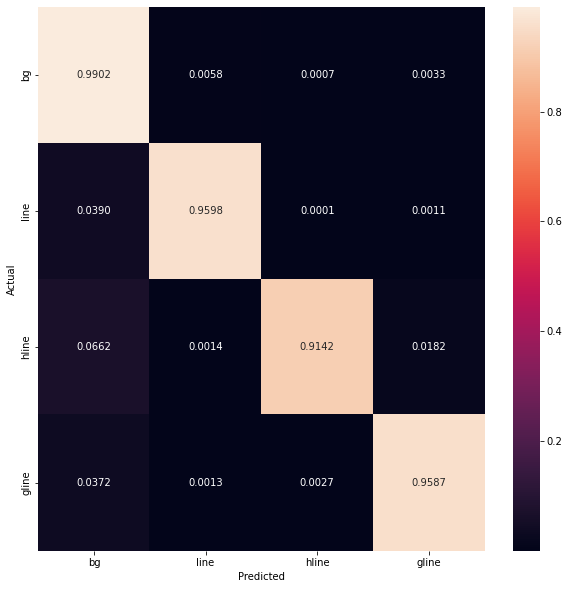

In [ ]:
# Normalise
import seaborn as sns
cmn = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.4f', xticklabels=CLASSES, yticklabels=CLASSES)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [ ]:
#Visualization
label_name = ['background', 'comments', 'decor', 'text']
label_colors = np.array([background, comments, decor, text])

In [ ]:
def visualize(temp):
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(len(label_colors)):
        r[temp==l]=label_colors[l,0]
        g[temp==l]=label_colors[l,1]
        b[temp==l]=label_colors[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = (r/255.0)#[:,:,0]
    rgb[:,:,1] = (g/255.0)#[:,:,1]
    rgb[:,:,2] = (b/255.0)#[:,:,2]
    return rgb

In [ ]:
from pathlib import Path

In [ ]:
output_path = Path('path to save predictions')
output_path.mkdir(exist_ok=True)

In [ ]:
for i in range(len(test_dataset)):

        
        image, mask = test_dataset[i]
        x_tensor = image.to(device).unsqueeze(0)
        pr_mask = Test_model(x_tensor.float())
        pr_mask_show = (pr_mask.squeeze().cpu().detach().numpy())
        pr_mask_show_2=np.argmax(pr_mask_show.transpose((1, 2, 0)), axis=2)
        diva_out = (visualize(pr_mask_show_2)*255).astype(np.uint8)
        diva_out=Image.fromarray(diva_out)
        diva_out.save(f'path to save predictions/image_{i}.gif')